Pruebas en el modelo v6

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from detectors.detector_factory import detector_factory

image_ext = ['jpg', 'jpeg', 'png', 'webp']
video_ext = ['mp4', 'mov', 'avi', 'mkv']
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']

In [3]:
sys.argv = ['-f', 'ctdetv2', '--demo', '../images/yolo/', '--arch','dlav6_34',  '--load_model' ,'../exp/ctdetv2/coco_dlav6/model_best.pth'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\default
ctdetv2


In [4]:
opt = opts().init()

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\default
heads {'hm': 80, 'wh': 2, 'reg': 2}


In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.debug = max(opt.debug, 1)
Detector = detector_factory[opt.task]
detector = Detector(opt)

Creating model...
loaded ../exp/ctdetv2/coco_dlav6/model_best.pth, epoch 130


In [6]:
image_names = [opt.demo]
#image_names.append('../images/Perro1.jpg')
"""
image_names.append('../images/aceite_4.png')
image_names.append('../images/cubix_0.png')
image_names.append('../images/cubix_5.png')
image_names.append('../images/te_0.png')
image_names.append('../images/te_8.png')
"""
image_names = []
ls = os.listdir(opt.demo)
for file_name in sorted(ls):
  ext = file_name[file_name.rfind('.') + 1:].lower()
  if ext in image_ext:
      image_names.append(os.path.join(opt.demo, file_name))
print(image_names)

['../images/yolo/aceite_0.png', '../images/yolo/aceite_4.png', '../images/yolo/aerosol_0.png', '../images/yolo/aerosol_4.png', '../images/yolo/azucarero_0.png', '../images/yolo/azucarero_4.png', '../images/yolo/balsamo_0.png', '../images/yolo/balsamo_4.png', '../images/yolo/borrador_0.png', '../images/yolo/borrador_4.png', '../images/yolo/cafe_0.png', '../images/yolo/cafe_5.png', '../images/yolo/cera_0.png', '../images/yolo/cera_4.png', '../images/yolo/coca_0.png', '../images/yolo/coca_5.png', '../images/yolo/colador_0.png', '../images/yolo/colador_5.png', '../images/yolo/cubix_0.png', '../images/yolo/cubix_5.png', '../images/yolo/leche_4.png', '../images/yolo/leche_8.png', '../images/yolo/pelota_0.png', '../images/yolo/pelota_3.png', '../images/yolo/te_0.png', '../images/yolo/te_8.png']


In [7]:
descriptores = {}
m = torch.nn.ReLU()
for (image_name) in image_names:
    print(image_name)
    ret = detector.run(image_name)
    output = ret['output']
    pred_obj = output['objns']
    hm = pred_obj.squeeze(0).squeeze(0)
    scores = output['hm'].squeeze(0)
    batch, cat, height, width = pred_obj.size()
    topk_scores, topk_inds = torch.topk(pred_obj.view(batch, cat, -1), 1)
    print(topk_scores)
    print(topk_inds)

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int()
    topk_xs   = (topk_inds % width).int()
    print(topk_ys[0,0,0])
    print(topk_xs[0,0,0])
    print(hm[topk_ys[0,0,0],topk_xs[0,0,0]])
    print(max(scores[:,topk_ys[0,0,0],topk_xs[0,0,0]]))
    descriptores[image_name] = torch.nn.ReLU()(output['descriptor'].squeeze(0)[:,int(topk_xs),int(topk_ys)])
    #descriptores[image_name] = (output['descriptor'].squeeze(0)[:,int(topk_xs),int(topk_ys)])
    print('-------------------------')

../images/yolo/aceite_0.png
tensor([[[0.9966]]], device='cuda:0')
tensor([[[11967]]], device='cuda:0')
tensor(93, device='cuda:0', dtype=torch.int32)
tensor(63, device='cuda:0', dtype=torch.int32)
tensor(0.9966, device='cuda:0')
tensor(0.1979, device='cuda:0')
-------------------------
../images/yolo/aceite_4.png
tensor([[[0.9970]]], device='cuda:0')
tensor([[[8383]]], device='cuda:0')
tensor(65, device='cuda:0', dtype=torch.int32)
tensor(63, device='cuda:0', dtype=torch.int32)
tensor(0.9970, device='cuda:0')
tensor(0.5870, device='cuda:0')
-------------------------
../images/yolo/aerosol_0.png
tensor([[[0.9996]]], device='cuda:0')
tensor([[[7744]]], device='cuda:0')
tensor(60, device='cuda:0', dtype=torch.int32)
tensor(64, device='cuda:0', dtype=torch.int32)
tensor(0.9996, device='cuda:0')
tensor(0.4529, device='cuda:0')
-------------------------
../images/yolo/aerosol_4.png
tensor([[[0.9997]]], device='cuda:0')
tensor([[[8002]]], device='cuda:0')
tensor(62, device='cuda:0', dtype=tor

In [29]:
descriptores = {}
heatmaps = {}
m = torch.nn.ReLU()
for (image_name) in image_names:
    print(image_name)
    ret = detector.run(image_name)
    output = ret['output']
    pred_obj = output['objns']
    hm = pred_obj.squeeze(0).squeeze(0)
    scores = output['hm'].squeeze(0)
    batch, cat, height, width = pred_obj.size()
    topk_scores, topk_inds = torch.topk(pred_obj.view(batch, cat, -1), 1)
    print(topk_scores)
    print(topk_inds)

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int()
    topk_xs   = (topk_inds % width).int()
    print(topk_ys[0,0,0])
    print(topk_xs[0,0,0])
    print(hm[62,64])
    print(max(scores[:,62,64]))
    descriptores[image_name] = torch.nn.ReLU()(output['descriptor'].squeeze(0)[:,62,64])
    heatmaps[image_name] = hm
    #descriptores[image_name] = (output['descriptor'].squeeze(0)[:,int(topk_xs),int(topk_ys)])
    print('-------------------------')

../images/yolo/aceite_0.png
tensor([[[0.9966]]], device='cuda:0')
tensor([[[11967]]], device='cuda:0')
tensor(93, device='cuda:0', dtype=torch.int32)
tensor(63, device='cuda:0', dtype=torch.int32)
tensor(0.8807, device='cuda:0')
tensor(0.1925, device='cuda:0')
-------------------------
../images/yolo/aceite_4.png
tensor([[[0.9970]]], device='cuda:0')
tensor([[[8383]]], device='cuda:0')
tensor(65, device='cuda:0', dtype=torch.int32)
tensor(63, device='cuda:0', dtype=torch.int32)
tensor(0.6257, device='cuda:0')
tensor(0.2452, device='cuda:0')
-------------------------
../images/yolo/aerosol_0.png
tensor([[[0.9996]]], device='cuda:0')
tensor([[[7744]]], device='cuda:0')
tensor(60, device='cuda:0', dtype=torch.int32)
tensor(64, device='cuda:0', dtype=torch.int32)
tensor(0.6812, device='cuda:0')
tensor(0.2412, device='cuda:0')
-------------------------
../images/yolo/aerosol_4.png
tensor([[[0.9997]]], device='cuda:0')
tensor([[[8002]]], device='cuda:0')
tensor(62, device='cuda:0', dtype=tor

In [8]:
from torch.nn.functional import normalize
import numpy as np

In [9]:
def cosdis(x,y):
    x = x.unsqueeze(0)
    y = y.unsqueeze(1)
    x_n = normalize(x,dim=1)
    y_n = normalize(y,dim=0)
    return x_n@y_n

In [19]:
D = []
for i in range(len(image_names)):
    D.append(descriptores[image_names[i]])

In [20]:
matrix = torch.zeros((len(image_names),len(image_names)))
for i in range(len(image_names)):
    for j in range(len(image_names)):
        score = cosdis(D[i],D[j])[0,0]
        matrix[i,j]=score  
    
np_matrix = np.array(matrix)

In [21]:
image_names_ext = [n[n.rfind('/')+1:n.rfind('_')] for n in image_names]
image_names_ext2 = [n[n.rfind('/')+1:n.rfind('.')] for n in image_names]

In [22]:
for i in range(len(image_names)):
    for j in range(len(image_names)):
        if i==j:
            matrix[i,j]=0

In [23]:
fallos = []
aciertos = []

count = 0
for i in range(len(image_names)):
    if image_names_ext[i] == image_names_ext[int(matrix[i].argmax())]:
        aciertos.append(image_names_ext2[i]+'|'+image_names_ext2[int(matrix[i].argmax())])
        count+=1
    else:
        fallos.append(image_names_ext2[i]+'|'+image_names_ext2[int(matrix[i].argmax())])      
        
        
acc = count/len(image_names)

In [24]:
fallos

['balsamo_0|aerosol_0',
 'borrador_4|te_8',
 'cera_0|aerosol_4',
 'cera_4|aerosol_4',
 'coca_5|aceite_0',
 'leche_4|cera_0',
 'leche_8|te_8',
 'te_8|leche_8']

In [25]:
aciertos

['aceite_0|aceite_4',
 'aceite_4|aceite_0',
 'aerosol_0|aerosol_4',
 'aerosol_4|aerosol_0',
 'azucarero_0|azucarero_4',
 'azucarero_4|azucarero_0',
 'balsamo_4|balsamo_0',
 'borrador_0|borrador_4',
 'cafe_0|cafe_5',
 'cafe_5|cafe_0',
 'coca_0|coca_5',
 'colador_0|colador_5',
 'colador_5|colador_0',
 'cubix_0|cubix_5',
 'cubix_5|cubix_0',
 'pelota_0|pelota_3',
 'pelota_3|pelota_0',
 'te_0|te_8']

In [26]:
print(acc)

0.6923076923076923


In [27]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

<AxesSubplot:>

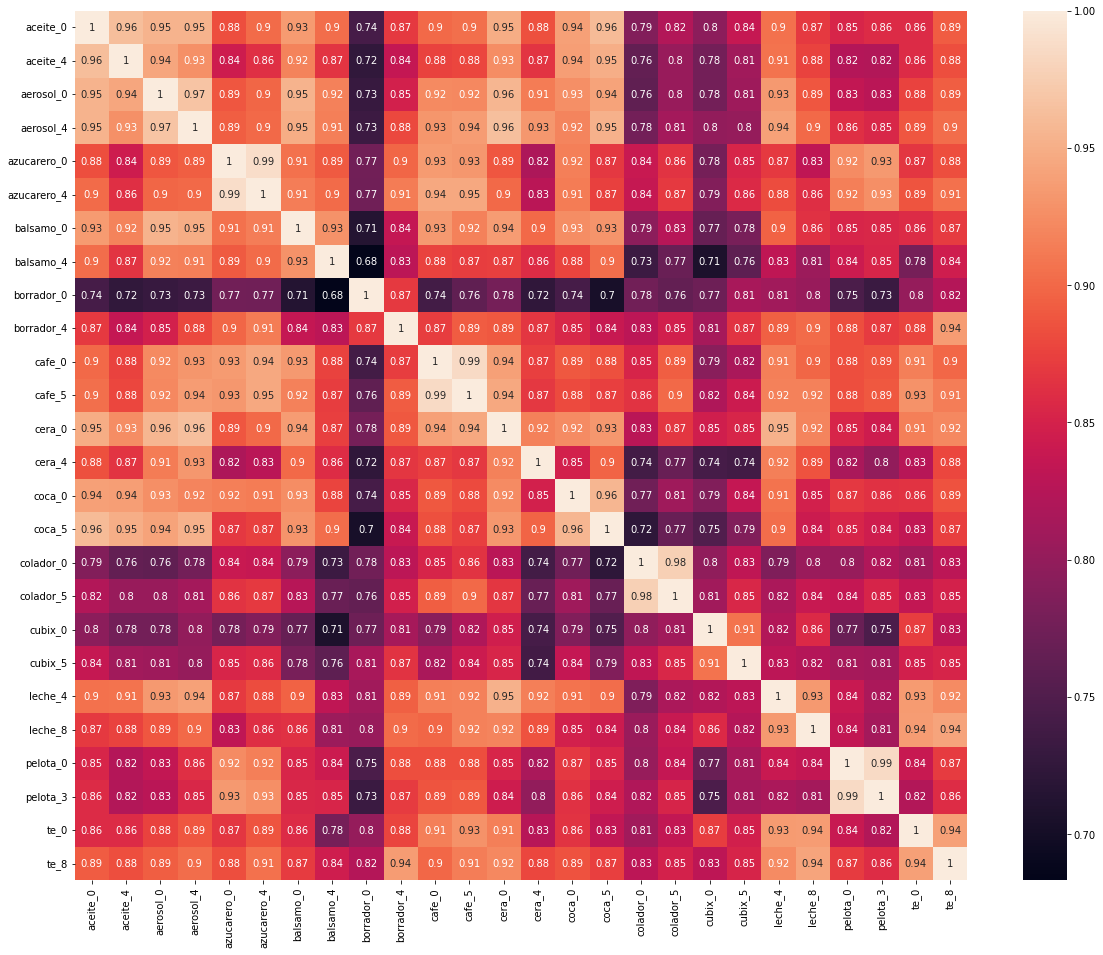

In [28]:
df_cm = pd.DataFrame(np_matrix, index = [i for i in image_names_ext2],
                  columns = [i for i in image_names_ext2])
plt.figure(figsize = (20,16))
sn.heatmap(df_cm, annot=True)

aceite_0
aceite_4
aerosol_0
aerosol_4
azucarero_0
azucarero_4
balsamo_0
balsamo_4
borrador_0
borrador_4
cafe_0
cafe_5
cera_0
cera_4
coca_0
coca_5
colador_0
colador_5
cubix_0
cubix_5
leche_4
leche_8
pelota_0
pelota_3
te_0
te_8


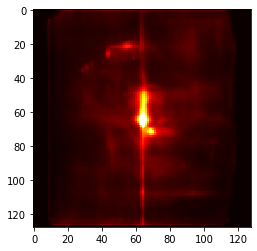

In [53]:
for i,img_name in enumerate(heatmaps):
    
    print(image_names_ext2[i])
    plt.imshow(heatmaps[img_name].detach().cpu().numpy(), cmap='hot', interpolation='nearest')
    plt.savefig('hm_'+image_names_ext2[i]+'.png')
